# Simulation statistics

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_statistics_data(filenames, timestep, t_stop, runs):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    statistics_matrix = np.zeros((runs, int(t_stop/timestep)+1, 3))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        stat_data = np.load(file=os.path.join(results_folder, filename))
        statistics_matrix[i, :, 0] = stat_data[:, 1]
        statistics_matrix[i, :, 1] = stat_data[:, 2]
        statistics_matrix[i, :, 2] = stat_data[:, 3]
    return times, np.mean(statistics_matrix, axis=0)

## Statistics

In [4]:
def plot_statistics(N, xi, rad, tstop, timestep, runs=4, pbc=True):
    if pbc:
        filenames = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    else:
        filenames = f"simulation_statistics_rbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
     
    print(filenames)
    
    times, stat_matrix = read_and_return_statistics_data(filenames, timestep, tstop, runs)
    avg_energy, length_coll_q, avg_numb_colls = stat_matrix[:, 0], stat_matrix[:, 1], stat_matrix[:, 2]
    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 12))
    
    print("E_0: ", avg_energy[0])
    print(f'-------- eta: {np.round(N*4*np.pi*rad**3/3, 3)} xi: {xi} ----------')
    
    axes[0].plot(times, avg_energy/avg_energy[0])
    if xi == 1:
        axes[0].set_ylim([0.99, 1.01])
    axes[0].set_ylabel(r'$\langle E \rangle / \langle E \rangle_0 $')
    #axes[0].set_title('Average particle energy')
    
    axes[1].plot(times, np.log(length_coll_q))
    #axes[1].plot(times, length_coll_q)
    #axes[1].set_ylabel(r'$n_q$')
    axes[1].set_ylabel(r'$\log{(n_q)}$')
    
    axes[2].plot(times, avg_numb_colls)
    axes[2].set_ylabel(r'$\bar{c}$')
    axes[2].set_xlabel(r'$t$')
    #axes[0].set_title(r'Simulation statistics for $\eta={}$ and $\xi={}$'.format(np.round(N*4*np.pi*rad**3/3, 3), xi))
    #fig.suptitle(r'Simulation statistics for $\eta={}$ and $\xi={}$'.format(np.round(N*4*np.pi*rad**3/3, 3), xi))
    
    plt.show()
    

In [5]:
def compare_pbc_rbc_one_statistic(N, xi, rad, tstop, timestep, runs, stat_choice):
    """
        Stat_choice: 0 -> energy, 1 -> length_coll_q and 2-> avg_numb_collisions
    """
    filenames_pbc = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    
    filenames_rbc = f"simulation_statistics_rbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
     
    print(filenames_pbc)
    print(filenames_rbc)
    
    times, stat_matrix_pbc = read_and_return_statistics_data(filenames_pbc, timestep, tstop, runs)
    times, stat_matrix_rbc = read_and_return_statistics_data(filenames_rbc, timestep, tstop, runs)
    data_pbc = stat_matrix_pbc[:, stat_choice]
    data_rbc = stat_matrix_rbc[:, stat_choice]
    
    plt.figure()
    if stat_choice == 0:
        print('--- Avg energy ---')
        if xi == 1:
            plt.plot(times, data_pbc/data_pbc[0]-1, label='PBC')
            plt.plot(times, data_rbc/data_rbc[0]-1, label='RBC')
            plt.ylabel(r'$\langle E \rangle / \langle E \rangle_0 - 1$')
        else:
            plt.plot(times, data_pbc/data_pbc[0], label='PBC')
            plt.plot(times, data_rbc/data_rbc[0], label='RBC')
            plt.ylabel(r'$\langle E \rangle / \langle E \rangle_0 $')
        #plt.title('Average energy')
        plt.xlabel(r'$t$')
        plt.legend()
        plt.savefig(os.path.join(plots_folder, f'avg_energy_bc_N_{N}_xi_{xi}_rad_{rad}.pdf'))
        plt.show()
    elif stat_choice == 1:
        print('--- Length priotity queue ---')
        plt.plot(times, np.log(data_pbc), label='PBC')
        plt.plot(times, np.log(data_rbc), label='RBC')
        plt.ylabel(r'$\log{(n_q)}$')
        #plt.title('Length of priority queue')
        plt.xlabel(r'$t$')
        plt.legend()
        plt.savefig(os.path.join(plots_folder, f'length_collision_queue_bc_N_{N}_xi_{xi}_rad_{rad}.pdf'))
        plt.show()
    elif stat_choice == 2:
        print('--- Avgerage number of collisions ---')
        plt.plot(times, data_pbc, label='PBC')
        plt.plot(times, data_rbc, label='RBC')
        plt.ylabel(r'$\bar{c}$')
        #plt.title('Average number of collisions')
        plt.xlabel(r'$t$')
        plt.legend()
        plt.savefig(os.path.join(plots_folder, f'avg_numb_coll_bc_N_{N}_xi_{xi}_rad_{rad}.pdf'))
        plt.show()

In [6]:
def compare_pbc_rbc_mg_gg_one_statistic(N, xi_values, rad, tstop, timestep, runs, stat_choice):
    """
        Stat_choice: 0 -> energy, 1 -> length_coll_q and 2-> avg_numb_collisions
    """
    if stat_choice != 0:
        plt.figure()
    xi_prefix = ['Molecular gas', 'Granular gas']
    for counter, xi in enumerate(xi_values):
        filenames_pbc = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"

        filenames_rbc = f"simulation_statistics_rbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"

        print(filenames_pbc)
        print(filenames_rbc)

        times, stat_matrix_pbc = read_and_return_statistics_data(filenames_pbc, timestep, tstop, runs)
        times, stat_matrix_rbc = read_and_return_statistics_data(filenames_rbc, timestep, tstop, runs)
        data_pbc = stat_matrix_pbc[:, stat_choice]
        data_rbc = stat_matrix_rbc[:, stat_choice]

        
        if stat_choice == 0:
            print('--- Avg energy ---')
            print('Should not use this function as mg and gg are plotted very differently for this statistics')
        elif stat_choice == 1:
            print('--- Length priotity queue ---')
            if counter == 0:
                plt.plot(times, np.log(data_pbc), label=xi_prefix[counter]+' PBC')
                plt.plot(times, np.log(data_rbc), label=xi_prefix[counter]+' RBC')
            else:
                plt.plot(times, np.log(data_pbc), '--', label=xi_prefix[counter]+' PBC')
                plt.plot(times, np.log(data_rbc), '--', label=xi_prefix[counter]+' RBC')
                plt.ylabel(r'$\log{(n_q)}$')
                #plt.title('Length of priority queue')
                plt.xlabel(r'$t$')
                plt.legend()
                plt.savefig(os.path.join(plots_folder, f'compare_xi_length_collision_queue_bc_N_{N}_rad_{rad}.pdf'))
                plt.show()
        elif stat_choice == 2:
            print('--- Avgerage number of collisions ---')
            if counter == 0:
                plt.plot(times, data_pbc, label=xi_prefix[counter]+' PBC')
                plt.plot(times, data_rbc, label=xi_prefix[counter]+' RBC')
            else:
                plt.plot(times, data_pbc, '--', label=xi_prefix[counter]+' PBC')
                plt.plot(times, data_rbc, '--', label=xi_prefix[counter]+' RBC')
                plt.ylabel(r'$\bar{c}$')
                #plt.title('Average number of collisions')
                plt.xlabel(r'$t$')
                plt.legend()
                plt.savefig(os.path.join(plots_folder, f'compare_xi_avg_numb_coll_bc_N_{N}_rad_{rad}.pdf'))
                plt.show()

## Numerical values

### Molecular gas, xi = 1

In [7]:
N = 1000
xi = 1
rad = 1/40
tstop = 10
timestep = 0.1

simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
E_0:  0.9994392429920347
-------- eta: 0.065 xi: 1 ----------


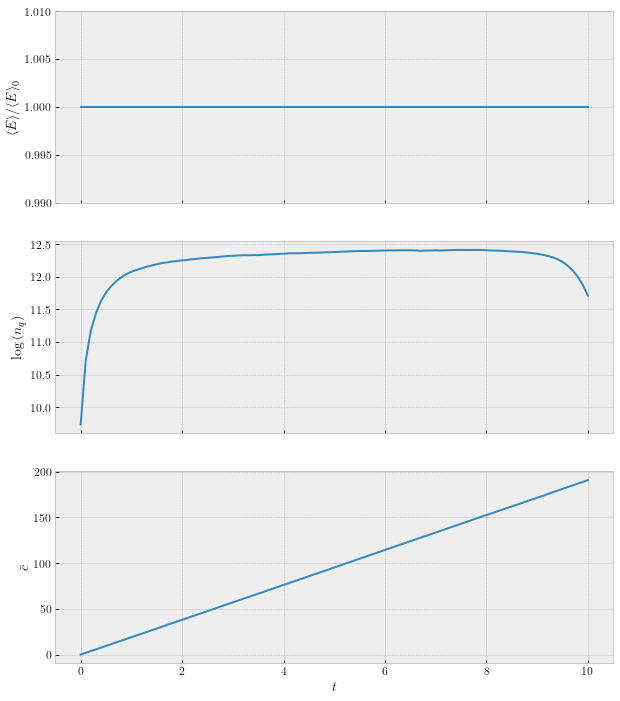

In [8]:
plot_statistics(N, xi, rad, tstop, timestep)

simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
E_0:  0.9994392429920348
-------- eta: 0.065 xi: 1 ----------


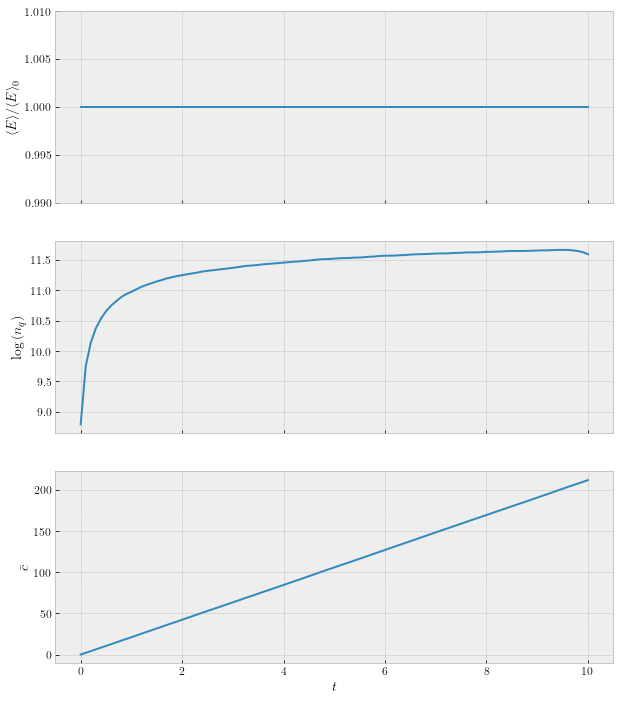

In [9]:
plot_statistics(N, xi, rad, tstop, timestep, pbc=False)

### Granular gas, xi < 1

In [10]:
xi = 0.8

simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
E_0:  0.9994392429920348
-------- eta: 0.065 xi: 0.8 ----------


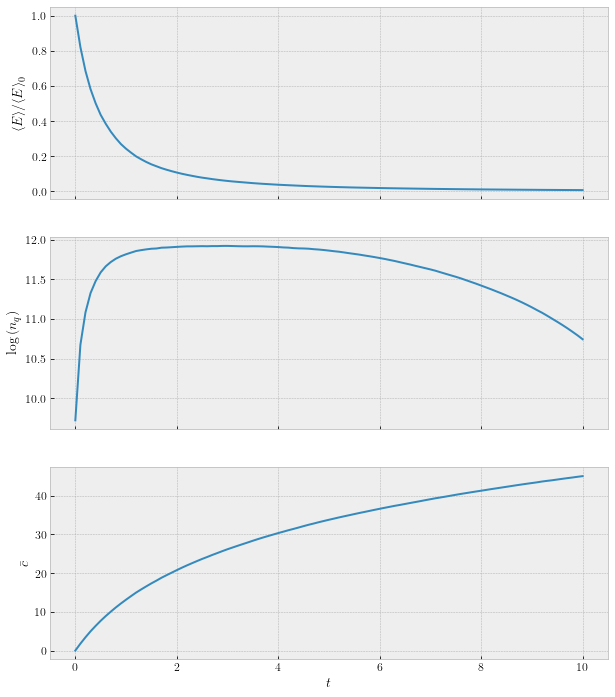

In [11]:
plot_statistics(N, xi, rad, tstop, timestep, pbc=True)

simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
E_0:  0.9994392429920348
-------- eta: 0.065 xi: 0.8 ----------


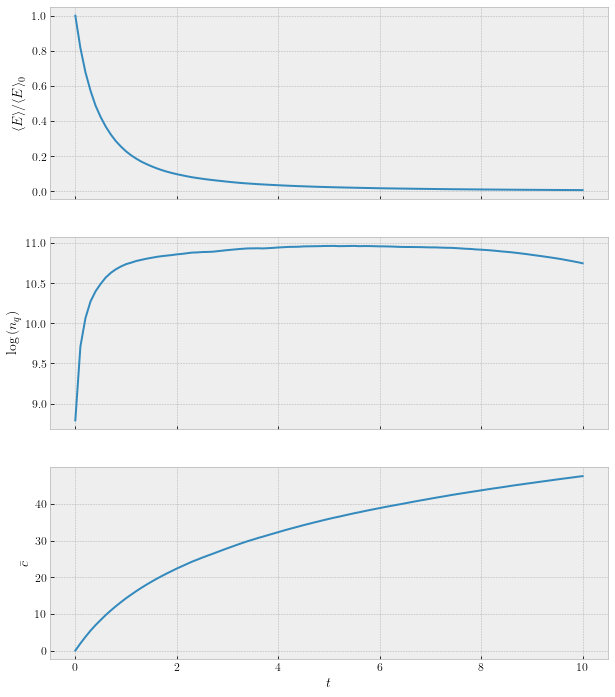

In [12]:
plot_statistics(N, xi, rad, tstop, timestep, pbc=False)

## Compare RBC and PBC

------ xi : 1 ---------
simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Avg energy ---


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


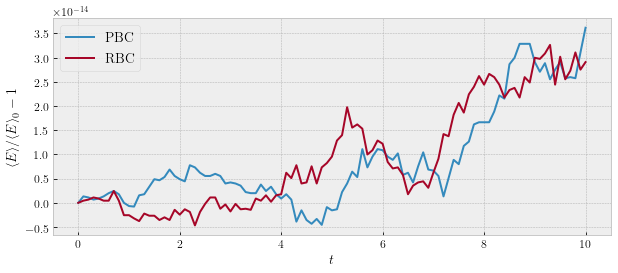

simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Length priotity queue ---


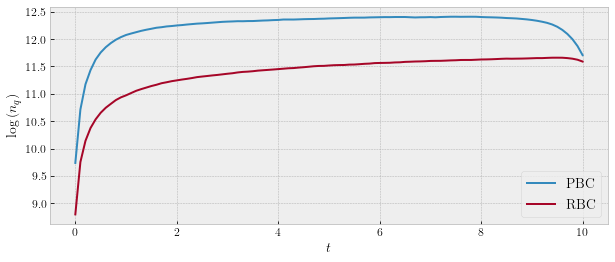

simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Avgerage number of collisions ---


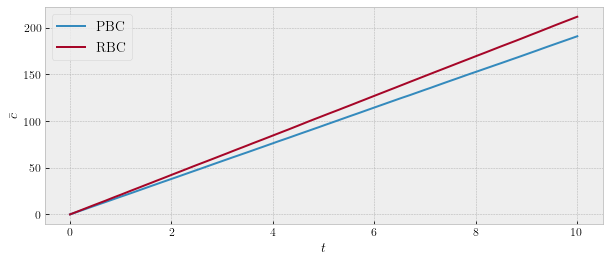

------ xi : 0.8 ---------
simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Avg energy ---


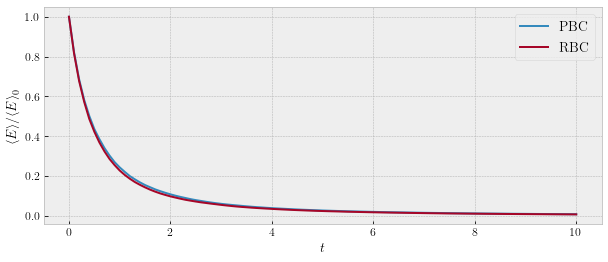

simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Length priotity queue ---


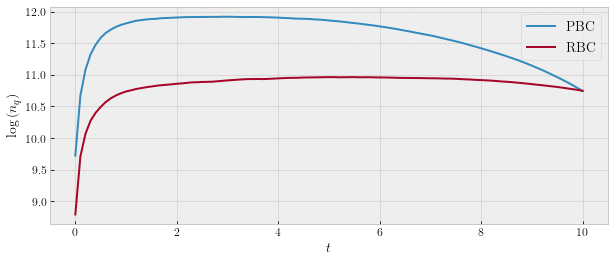

simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Avgerage number of collisions ---


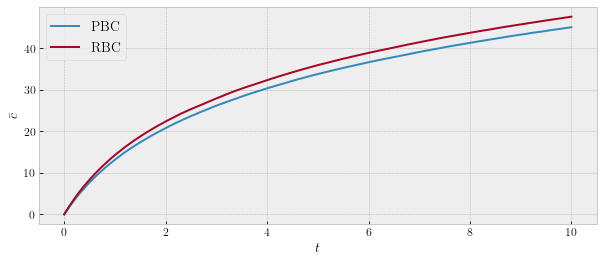

In [13]:
N = 1000
xi_values = [1, 0.8]
rad = 1/40
tstop = 10
timestep = 0.1
stat_choices = [0, 1, 2]
runs = 4

for xi in xi_values:
    print(f'------ xi : {xi} ---------')
    for stat_choice in stat_choices:
        compare_pbc_rbc_one_statistic(N, xi, rad, tstop, timestep, runs, stat_choice)

## Compare molecular gas, granular gas for both boundary conditions

simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Avg energy ---
Should not use this function as mg and gg are plotted very differently for this statistics
simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Avg energy ---
Should not use this function as mg and gg are plotted very differently for this statistics
simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Length priotity queue ---
simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Length priotity queue ---


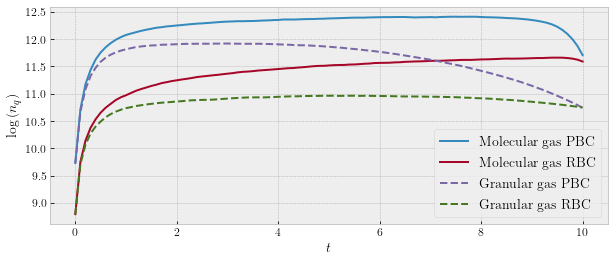

simulation_statistics_pbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_1_tstop_10_lgtc_-inf_X.npy
--- Avgerage number of collisions ---
simulation_statistics_pbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_10_lgtc_-inf_X.npy
--- Avgerage number of collisions ---


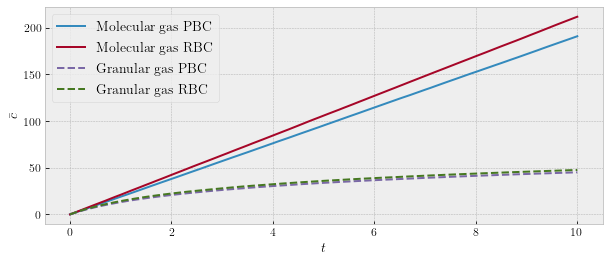

In [14]:
N = 1000
xi_values = [1, 0.8]
rad = 1/40
tstop = 10
timestep = 0.1
stat_choices = [0, 1, 2]
runs = 4

for stat_choice in stat_choices:
    compare_pbc_rbc_mg_gg_one_statistic(N, xi_values, rad, tstop, timestep, runs, stat_choice)